In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import numpy as np
import sqlite3
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from gensim.models import word2vec
from gensim.models import keyedvectors
import pickle
from tqdm import tqdm
import os

In [6]:
con = sqlite3.connect('E:/Varun/amazon-fine-food-reviews/database.sqlite')
filtered_data = pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score !=3
''', con)
def partition(x):
    if x > 3:
        return "positive"
    return "negative" 
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)

filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [7]:
sorted_data = filtered_data.sort_values('ProductId', axis= 0, ascending= True, inplace=False, kind=
'quicsort', na_position = 'last')

In [8]:
final_data= sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, keep='first',
inplace=False)
final=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]
final.shape
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
#Taking a sample of 2K Positive reviews and 2K Negative reviews
p = final[final['Score'] == "positive"]
p = p[:2000]
n= final[final['Score'] == "negative"]
n = n[:2000]
p.shape
n.shape
final_data=pd.concat([p,n])
final_data.shape

(4000, 10)

In [10]:
labels = final_data['Score']
labels.shape

(4000,)

In [11]:
#Preprocessing

In [12]:
import re
i=0;
for sent in final_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break
    i += 1


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [13]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

if not os.path.isfile('sample.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[]
    all_negative_words=[]
    s=''
    for sent in tqdm(final_data['Text'].values):
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final_data['Score'].values)[i] == 'positive':
                            all_positive_words.append(s)
                        if(final_data['Score'].values)[i] == 'negative':
                            all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue
        str1 = b" ".join(filtered_sentence)

        final_string.append(str1)
        i+=1
    
    final_data['CleanedText']=final_string
    final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")
    conn = sqlite3.connect('sample.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final_data.to_sql('Reviews', conn, schema=None, if_exists='replace', \
    index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
if os.path.isfile('sample.sqlite'):
    conn = sqlite3.connect('sample.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [38]:
# Time based Splitting the data into 70% train and 30% test
X = final['CleanedText']
Y = final['Score']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

X1, Xtest, Y1, Ytest = cross_validation.train_test_split(X,Y,test_size=0.3, random_state=0)
#Xtr, Xcv, Ytr, Ycv = cross_validation.train_test_split(X1,Y1,test_size=0.3)


In [39]:
# Computing BagofWords for both train and test data
count_vect = CountVectorizer()
Xtr_bow = count_vect.fit_transform(Xtr)
Xtest_bow = count_vect.transform(Xtest)
#Xcv_bow = count_vect.fit_transform(Xcv)

In [41]:
#Training and Prediction using KNN
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(Xtr_bow, Ytr)
    prediction = knn.predict(Xtest_bow)
    accuracy = accuracy_score(Ytest, prediction, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, accuracy))

knn = KNeighborsClassifier(1)
knn.fit(Xtr_bow,Ytr)
prediction = knn.predict(Xtest_bow)
accuracy = accuracy_score(Ytest, prediction, normalize=True) * float(100)
print('\nCV accuracy for k = 1 is %d%%' % (accuracy))


CV accuracy for k = 1 is 71%

CV accuracy for k = 3 is 73%

CV accuracy for k = 5 is 75%

CV accuracy for k = 7 is 75%

CV accuracy for k = 9 is 77%

CV accuracy for k = 11 is 77%

CV accuracy for k = 13 is 79%

CV accuracy for k = 15 is 79%

CV accuracy for k = 17 is 80%

CV accuracy for k = 19 is 80%

CV accuracy for k = 21 is 80%

CV accuracy for k = 23 is 81%

CV accuracy for k = 25 is 81%

CV accuracy for k = 27 is 81%

CV accuracy for k = 29 is 81%

CV accuracy for k = 1 is 71%



 The optimal no of neighbors is 37 


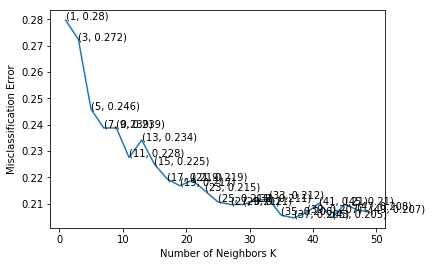

the misclassification error for each k value is :  [0.28  0.272 0.246 0.239 0.239 0.228 0.234 0.225 0.219 0.217 0.219 0.215
 0.211 0.21  0.21  0.211 0.212 0.206 0.205 0.207 0.21  0.205 0.21  0.208
 0.207]


In [43]:
# 10 Fold Cross Validation

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtr_bow, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))




In [52]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(Xtr_bow, Ytr)

# predict the response
prediction = knn_optimal.predict(Xtest_bow)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, accuracy))


The accuracy of the knn classifier for k = 37 is 81.833333%



 The optimal no of neighbors is 37 


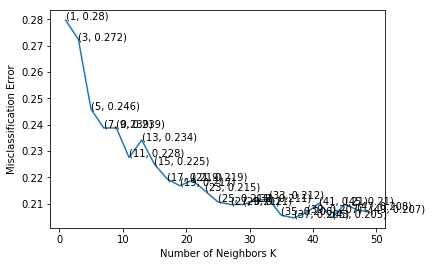

the misclassification error for each k value is :  [0.28  0.272 0.246 0.239 0.239 0.228 0.234 0.225 0.219 0.217 0.219 0.215
 0.211 0.21  0.21  0.211 0.212 0.206 0.205 0.207 0.21  0.205 0.21  0.208
 0.207]

The accuracy of the knn classifier for k = 37 is 81.833333%


In [55]:
#Computing the optimal_k using kd_tree

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')
    scores = cross_val_score(knn, Xtr_bow, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k_kd_tree = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k_kd_tree)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

knn_kd_tree = KNeighborsClassifier(n_neighbors = optimal_k_kd_tree)
knn_kd_tree.fit(Xtr_bow, Ytr)
# predict the response
prediction = knn_kd_tree.predict(Xtest_bow)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_kd_tree, accuracy))


 The optimal no of neighbors is 37 


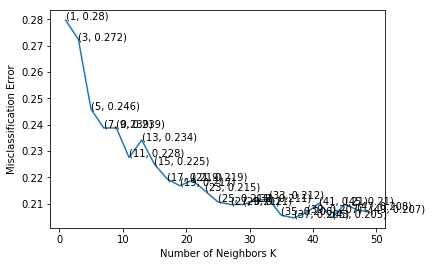

the misclassification error for each k value is :  [0.28  0.272 0.246 0.239 0.239 0.228 0.234 0.225 0.219 0.217 0.219 0.215
 0.211 0.21  0.21  0.211 0.212 0.206 0.205 0.207 0.21  0.205 0.21  0.208
 0.207]

The accuracy of the knn classifier for k = 37 is 81.833333%


In [56]:
#Computing the optimal_k using brute force

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'brute')
    scores = cross_val_score(knn, Xtr_bow, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k_brute = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k_brute)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

knn_brute = KNeighborsClassifier(n_neighbors = optimal_k_brute)
knn_brute.fit(Xtr_bow, Ytr)
# predict the response
prediction = knn_brute.predict(Xtest_bow)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_brute, accuracy))

In [62]:
# KNN for TF-IDF
tf_idf_vect = TfidfVectorizer()
Xtr_tf_idf = tf_idf_vect.fit_transform(Xtr)
Xtest_tf_idf = tf_idf_vect.transform(Xtest)





 The optimal no of neighbors is 9 


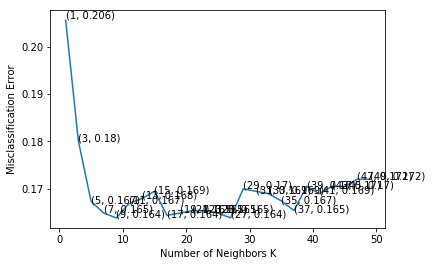

the misclassification error for each k value is :  [0.206 0.18  0.167 0.165 0.164 0.167 0.168 0.169 0.164 0.165 0.165 0.165
 0.165 0.164 0.17  0.169 0.169 0.167 0.165 0.17  0.169 0.17  0.17  0.172
 0.172]


In [63]:
# 10 Fold Cross Validation

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtr_tf_idf, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))




In [64]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(Xtr_tf_idf, Ytr)

# predict the response
prediction = knn_optimal.predict(Xtest_tf_idf)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, accuracy))


The accuracy of the knn classifier for k = 9 is 84.583333%



 The optimal no of neighbors is 9 


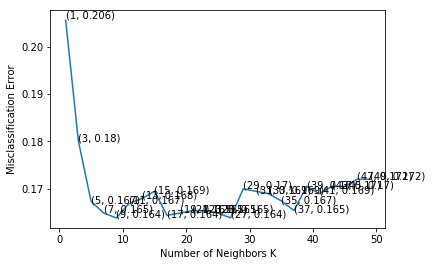

the misclassification error for each k value is :  [0.206 0.18  0.167 0.165 0.164 0.167 0.168 0.169 0.164 0.165 0.165 0.165
 0.165 0.164 0.17  0.169 0.169 0.167 0.165 0.17  0.169 0.17  0.17  0.172
 0.172]

The accuracy of the knn classifier for k = 9 is 84.583333%


In [66]:
#Computing the optimal_k using kd_tree for tf-idf

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')
    scores = cross_val_score(knn, Xtr_tf_idf, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k_kd_tree = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k_kd_tree)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

knn_kd_tree = KNeighborsClassifier(n_neighbors = optimal_k_kd_tree)
knn_kd_tree.fit(Xtr_tf_idf, Ytr)
# predict the response
prediction = knn_kd_tree.predict(Xtest_tf_idf)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_kd_tree, accuracy))


 The optimal no of neighbors is 9 


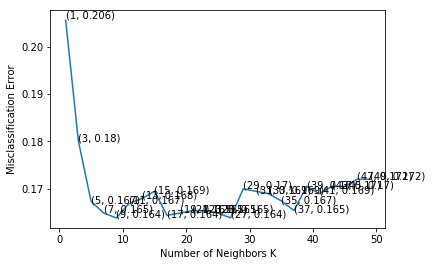

the misclassification error for each k value is :  [0.206 0.18  0.167 0.165 0.164 0.167 0.168 0.169 0.164 0.165 0.165 0.165
 0.165 0.164 0.17  0.169 0.169 0.167 0.165 0.17  0.169 0.17  0.17  0.172
 0.172]

The accuracy of the knn classifier for k = 9 is 84.583333%


In [67]:
#Computing the optimal_k using brute force

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'brute')
    scores = cross_val_score(knn, Xtr_tf_idf, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k_brute = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k_brute)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

knn_brute = KNeighborsClassifier(n_neighbors = optimal_k_brute)
knn_brute.fit(Xtr_tf_idf, Ytr)
# predict the response
prediction = knn_brute.predict(Xtest_tf_idf)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_brute, accuracy))

In [86]:
#Word2Vec
i=0
Xtr_w2v=[]
Xtest_w2v = []
for sent in Xtr:
    Xtr_w2v.append(sent.split())
for sent in Xtest:
    Xtest_w2v.append(sent.split())

In [88]:
from gensim.models import Word2Vec
w2v_model_list = Word2Vec(Xtr_w2v,min_count=5,size=50, workers=4)
w2v_words_tr = list(w2v_model_list.wv.vocab)

#Avg Word2Vec
sent_vectors_tr = []
for sent in tqdm(Xtr_w2v):
    sent_vec = np.zeros(50)
    count_words =0
    for word in sent:
        if word in w2v_words_tr:
            vec = w2v_model_tr.wv[word]
            sent_vec += vec
            count_words += 1
    if count_words != 0:
        sent_vec /= count_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:04<00:00, 477.36it/s]


1960
50


In [89]:
w2v_model_list = Word2Vec(Xtest_w2v,min_count=5,size=50, workers=4)
w2v_words_test = list(w2v_model_list.wv.vocab)

sent_vectors_test = []
for sent in tqdm(Xtest_w2v):
    sent_vec = np.zeros(50)
    count_words =0
    for word in sent:
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            count_words += 1
    if count_words != 0:
        sent_vec /= count_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_tr[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:02<00:00, 553.93it/s]


1200
50



 The optimal no of neighbors is 5 


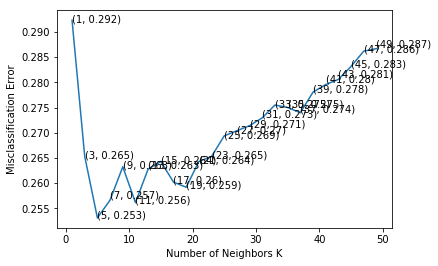

the misclassification error for each k value is :  [0.292 0.265 0.253 0.257 0.263 0.256 0.263 0.264 0.26  0.259 0.264 0.265
 0.269 0.27  0.271 0.273 0.275 0.275 0.274 0.278 0.28  0.281 0.283 0.286
 0.287]

The accuracy of the knn classifier for k = 5 is 75.333333%


In [90]:
# 10 Fold Cross Validation

Xtr_avg_w2v = sent_vectors_tr
Xtest_avg_w2v = sent_vectors_test

neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtr_avg_w2v, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# ------------------------------------------------------------------------------------------

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(Xtr_bow, Ytr)

# predict the response
prediction = knn_optimal.predict(Xtest_bow)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, accuracy))


 The optimal no of neighbors is 5 


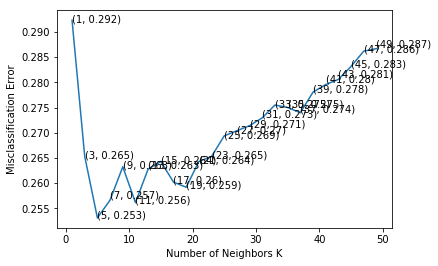

the misclassification error for each k value is :  [0.292 0.265 0.253 0.257 0.263 0.256 0.263 0.264 0.26  0.259 0.264 0.265
 0.269 0.27  0.271 0.273 0.275 0.275 0.274 0.278 0.28  0.281 0.283 0.286
 0.287]

The accuracy of the knn classifier for k = 5 is 51.916667%


In [92]:
#Computing the optimal_k using kd_tree for tf-idf

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')
    scores = cross_val_score(knn, Xtr_avg_w2v, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k_kd_tree = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k_kd_tree)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

knn_kd_tree = KNeighborsClassifier(n_neighbors = optimal_k_kd_tree)
knn_kd_tree.fit(Xtr_avg_w2v, Ytr)
# predict the response
prediction = knn_kd_tree.predict(Xtest_avg_w2v)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_kd_tree, accuracy))


 The optimal no of neighbors is 5 


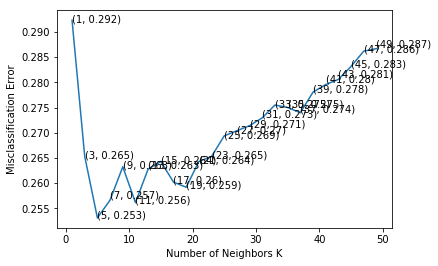

the misclassification error for each k value is :  [0.292 0.265 0.253 0.257 0.263 0.256 0.263 0.264 0.26  0.259 0.264 0.265
 0.269 0.27  0.271 0.273 0.275 0.275 0.274 0.278 0.28  0.281 0.283 0.286
 0.287]

The accuracy of the knn classifier for k = 5 is 51.916667%


In [93]:
#Computing the optimal_k using brute force

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'brute')
    scores = cross_val_score(knn, Xtr_avg_w2v, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k_brute = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k_brute)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

knn_brute = KNeighborsClassifier(n_neighbors = optimal_k_brute)
knn_brute.fit(Xtr_avg_w2v, Ytr)
# predict the response
prediction = knn_brute.predict(Xtest_avg_w2v)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_brute, accuracy))

In [104]:
#KNN for Tf-Idf Word2Vec Train

Xtr_w2v_tf_idf=[]
for sent in Xtr:
    Xtr_w2v_tf_idf.append(sent.split())

tf_idf_model = TfidfVectorizer()
tf_idf_matrix = tf_idf_model.fit_transform(Xtr)
dictionary = dict(zip(tf_idf_model.get_feature_names(), list(tf_idf_model.idf_)))

from gensim.models import Word2Vec
w2v_model_list = Word2Vec(Xtr_w2v_tf_idf,min_count=5,size=50, workers=4)
w2v_words_tr = list(w2v_model_list.wv.vocab)

tf_idf_feat = tf_idf_model.get_feature_names()
tf_idf_sent_vectors_tr = [];
row=0;

for sent in tqdm(Xtr_w2v_tf_idf):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words_tr:
            vec = w2v_model_tr.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tf_idf_sent_vectors_tr.append(sent_vec)
    row += 1

print('\n', len(tf_idf_sent_vectors_tr))
print(len(tf_idf_sent_vectors_tr[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:03<00:00, 558.35it/s]



 1960
50


In [105]:
#KNN for Tf-Idf Word2Vec Test

i=0
Xtest_w2v_tf_idf = []
for sent in Xtest:
    Xtest_w2v_tf_idf.append(sent.split())
    
tf_idf_model = TfidfVectorizer()
tf_idf_matrix = tf_idf_model.fit_transform(Xtest)
dictionary = dict(zip(tf_idf_model.get_feature_names(), list(tf_idf_model.idf_)))

from gensim.models import Word2Vec
w2v_model_list = Word2Vec(Xtest_w2v_tf_idf,min_count=5,size=50, workers=4)
w2v_words_test = list(w2v_model_list.wv.vocab)

tf_idf_feat = tf_idf_model.get_feature_names()
tf_idf_sent_vectors_test = [];
row=0;

for sent in tqdm(Xtest_w2v_tf_idf):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tf_idf_sent_vectors_test.append(sent_vec)
    row += 1

print('\n', len(tf_idf_sent_vectors_test))
print(len(tf_idf_sent_vectors_test[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:01<00:00, 605.06it/s]



 1200
50



 The optimal no of neighbors is 13 


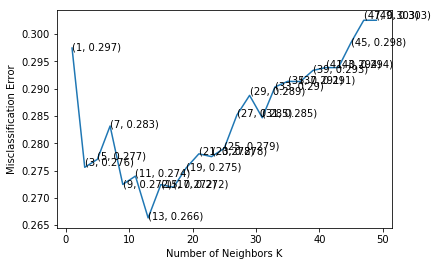

the misclassification error for each k value is :  [0.297 0.276 0.277 0.283 0.272 0.274 0.266 0.272 0.272 0.275 0.278 0.278
 0.279 0.285 0.289 0.285 0.29  0.291 0.291 0.293 0.294 0.294 0.298 0.303
 0.303]

The accuracy of the knn classifier for k = 13 is 55.250000%


In [106]:
# 10 Fold Cross Validation

Xtr_avg_w2v_tf_idf = tf_idf_sent_vectors_tr
Xtest_avg_w2v_tf_idf = tf_idf_sent_vectors_test

neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtr_avg_w2v_tf_idf, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

# ------------------------------------------------------------------------------------------

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(Xtr_avg_w2v_tf_idf, Ytr)

# predict the response
prediction = knn_optimal.predict(Xtest_avg_w2v_tf_idf)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, accuracy))


 The optimal no of neighbors is 13 


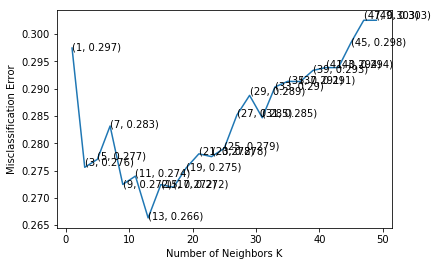

the misclassification error for each k value is :  [0.297 0.276 0.277 0.283 0.272 0.274 0.266 0.272 0.272 0.275 0.278 0.278
 0.279 0.285 0.289 0.285 0.29  0.291 0.291 0.293 0.294 0.294 0.298 0.303
 0.303]

The accuracy of the knn classifier for k = 13 is 55.250000%


In [107]:
#Computing the optimal_k using kd_tree for tf-idf

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'kd_tree')
    scores = cross_val_score(knn, Xtr_avg_w2v_tf_idf, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k_kd_tree = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k_kd_tree)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

knn_kd_tree = KNeighborsClassifier(n_neighbors = optimal_k_kd_tree)
knn_kd_tree.fit(Xtr_avg_w2v_tf_idf, Ytr)
# predict the response
prediction = knn_kd_tree.predict(Xtest_avg_w2v_tf_idf)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_kd_tree, accuracy))


 The optimal no of neighbors is 13 


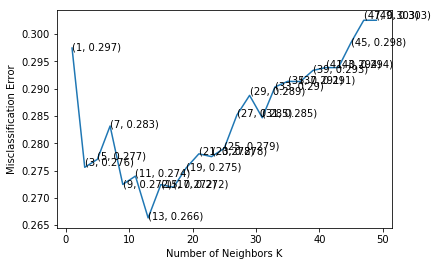

the misclassification error for each k value is :  [0.297 0.276 0.277 0.283 0.272 0.274 0.266 0.272 0.272 0.275 0.278 0.278
 0.279 0.285 0.289 0.285 0.29  0.291 0.291 0.293 0.294 0.294 0.298 0.303
 0.303]

The accuracy of the knn classifier for k = 13 is 55.250000%


In [108]:
#Computing the optimal_k using brute force

knnList = list(range(0,50))
neighbors = list(filter(lambda X: X % 2 != 0, knnList))

CVscores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm = 'brute')
    scores = cross_val_score(knn, Xtr_avg_w2v_tf_idf, Ytr, cv = 10, scoring = 'accuracy')
    CVscores.append(scores.mean())

MSE = [1 - X for X in CVscores]

optimal_k_brute = neighbors[MSE.index(min(MSE))]
print('\n The optimal no of neighbors is %d ' % optimal_k_brute)

plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

knn_brute = KNeighborsClassifier(n_neighbors = optimal_k_brute)
knn_brute.fit(Xtr_avg_w2v_tf_idf, Ytr)
# predict the response
prediction = knn_brute.predict(Xtest_avg_w2v_tf_idf)

# evaluate accuracy
accuracy = accuracy_score(Ytest, prediction) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_brute, accuracy))